__Background__:

I was inspired by one of Internet Historian video, [The Engoodening of No Man's Sky](https://www.youtube.com/watch?v=O5BJVO3PDeQ&t=1s), particularly this following segment:

"Then he starts breaking that (all the feedback of the game from various sources) down into datasets: people who haven't bought the game, people who have bought it and played it for a hundred hours, people who have returned it, etc. Then he starts compiling those complaints into usable data, focusing on the people with the most sincere experience of the game. Then he starts making a big list of all the things that need adding and prioritize them."

This workflow was really interesting to me, because it is applicable in many cases, especially in industry. So here it is, my first attempt on exploring the field of NLP. 

__Goals__:

Here, I am going to analyze the reviews on Steam games, a platform I mostly use to play video games. The exact goals of this project are:
- Analyze what words are associated with good reviews (reviewer recommended the game)
- Predicting whether a reviewer recommended the game or not based on the review

Obviously, this project is not going to be as grandeur as what Sean Murray did, but I would like to have a hands-on experience on sentiment analysis in general.

So please, enjoy!

In [58]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

# COLOR = 'black'
# mpl.rcParams['text.color'] = 'black'
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Load data
data = pd.read_csv("data_scraping/recent_reviews_2022.csv")

# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175873 entries, 0 to 175872
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   author             175873 non-null  object
 1   review             175234 non-null  object
 2   timestamp_created  175873 non-null  int64 
 3   voted_up           175873 non-null  bool  
 4   votes_up           175873 non-null  int64 
 5   votes_funny        175873 non-null  int64 
 6   name               175873 non-null  object
dtypes: bool(1), int64(3), object(3)
memory usage: 8.2+ MB


In [ ]:
# Check data content
data.head()

,author,review,timestamp_created,voted_up,votes_up,votes_funny,name
0,"{'steamid': '76561198876197793', 'num_games_ow...",YES!,1640995265,True,0,0,Microsoft Flight Simulator Game of the Year Ed...
1,"{'steamid': '76561198007107695', 'num_games_ow...","If you like crafting survival games, Icarus is...",1640995288,True,0,0,ICARUS
2,"{'steamid': '76561198103334117', 'num_games_ow...","officially addicted, I love this game. I wish ...",1640995389,True,0,0,New World
3,"{'steamid': '76561198124243445', 'num_games_ow...","Game should be $5, I could make a more grindab...",1640995448,False,8,1,Back 4 Blood
4,"{'steamid': '76561198355294063', 'num_games_ow...",I feel like since this game had a terrible lau...,1640995470,True,1,0,Cyberpunk 2077


Columns:
- `author`: The information in dictionary regarding the author of the review:
    - `steamid`: the user's steam ID.
    - `num_games_owned`: number of games owned by the user.
    - `num_reviews`: number of reviews written by the user.
    - `playtime_forever`: lifetime playtime tracked in this game.
    - `playtime_last_two_weeks`: playtime tracked in the past two weeks for this game.
    - `playtime_at_review`: playtime when the review was written (in minutes).
    - `last_played`: time for when the user last played this game.
- `review`: The text of user review.
- `timestamp_created`: date the review was created (unix timestamp).
- `voted_up`: Whether the reviewer recommended the game or not (True: recommended, False: not recommended).
- `votes_up`: How many other users think the review is helpful.
- `votes_funny`: How many other player think the review is funny.
- `name`: The game title being reviewed.

# 1. Preprocessing/Data Preparation

First, we will prepare the data so that it is easier to analyze. We will extract `steamid`, `num_games_owned`, `num_reviews`, and `playtime_at_review` from column `author` because it seems like an interesting feature to add.

In [ ]:
# Extract playtime_at_review
import json

data['steam_id'] = data['author'].apply(lambda x: json.loads(x.replace("'",'"'))['steamid'])
data['num_games_owned'] = data['author'].apply(lambda x: json.loads(x.replace("'",'"'))['num_games_owned'])
data['num_reviews'] = data['author'].apply(lambda x: json.loads(x.replace("'",'"'))['num_reviews'])
data['hour_played'] = data['author'].apply(lambda x: round(json.loads(x.replace("'",'"'))['playtime_at_review']/60))

data.head()

,author,review,timestamp_created,voted_up,votes_up,votes_funny,name,steam_id,num_games_owned,num_reviews,hour_played
0,"{'steamid': '76561198876197793', 'num_games_ow...",YES!,1640995265,True,0,0,Microsoft Flight Simulator Game of the Year Ed...,76561198876197793,28,10,25
1,"{'steamid': '76561198007107695', 'num_games_ow...","If you like crafting survival games, Icarus is...",1640995288,True,0,0,ICARUS,76561198007107695,1290,1,57
2,"{'steamid': '76561198103334117', 'num_games_ow...","officially addicted, I love this game. I wish ...",1640995389,True,0,0,New World,76561198103334117,220,2,253
3,"{'steamid': '76561198124243445', 'num_games_ow...","Game should be $5, I could make a more grindab...",1640995448,False,8,1,Back 4 Blood,76561198124243445,55,9,11
4,"{'steamid': '76561198355294063', 'num_games_ow...",I feel like since this game had a terrible lau...,1640995470,True,1,0,Cyberpunk 2077,76561198355294063,101,22,14


Next, we will convert the timestamps into date time format.

In [ ]:
from datetime import datetime

data['date_posted'] = pd.to_datetime(data['timestamp_created'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d')))

data.head()

,author,review,timestamp_created,voted_up,votes_up,votes_funny,name,steam_id,num_games_owned,num_reviews,hour_played,date_posted
0,"{'steamid': '76561198876197793', 'num_games_ow...",YES!,1640995265,True,0,0,Microsoft Flight Simulator Game of the Year Ed...,76561198876197793,28,10,25,2022-01-01
1,"{'steamid': '76561198007107695', 'num_games_ow...","If you like crafting survival games, Icarus is...",1640995288,True,0,0,ICARUS,76561198007107695,1290,1,57,2022-01-01
2,"{'steamid': '76561198103334117', 'num_games_ow...","officially addicted, I love this game. I wish ...",1640995389,True,0,0,New World,76561198103334117,220,2,253,2022-01-01
3,"{'steamid': '76561198124243445', 'num_games_ow...","Game should be $5, I could make a more grindab...",1640995448,False,8,1,Back 4 Blood,76561198124243445,55,9,11,2022-01-01
4,"{'steamid': '76561198355294063', 'num_games_ow...",I feel like since this game had a terrible lau...,1640995470,True,1,0,Cyberpunk 2077,76561198355294063,101,22,14,2022-01-01


Finally, we will convert the recommendation (`voted_up`) into strings for readability: 'Recommended' for True and 'Not Recommended' for False. We will also convert it to integers, and I will label 1 for the negative reviews, and 0 for the positive reviews, since the main purpose of this project is to detect the negative reviews as they convey more information regarding the problems of the game.

In [ ]:
data['recommendation'] = data['voted_up'].map({True:'Recommended', False:'Not Recommended'})
data['recommendation_int'] = (~data['voted_up']).astype(int)

data.head()

,author,review,timestamp_created,voted_up,votes_up,votes_funny,name,steam_id,num_games_owned,num_reviews,hour_played,date_posted,recommendation,recommendation_int
0,"{'steamid': '76561198876197793', 'num_games_ow...",YES!,1640995265,True,0,0,Microsoft Flight Simulator Game of the Year Ed...,76561198876197793,28,10,25,2022-01-01,Recommended,0
1,"{'steamid': '76561198007107695', 'num_games_ow...","If you like crafting survival games, Icarus is...",1640995288,True,0,0,ICARUS,76561198007107695,1290,1,57,2022-01-01,Recommended,0
2,"{'steamid': '76561198103334117', 'num_games_ow...","officially addicted, I love this game. I wish ...",1640995389,True,0,0,New World,76561198103334117,220,2,253,2022-01-01,Recommended,0
3,"{'steamid': '76561198124243445', 'num_games_ow...","Game should be $5, I could make a more grindab...",1640995448,False,8,1,Back 4 Blood,76561198124243445,55,9,11,2022-01-01,Not Recommended,1
4,"{'steamid': '76561198355294063', 'num_games_ow...",I feel like since this game had a terrible lau...,1640995470,True,1,0,Cyberpunk 2077,76561198355294063,101,22,14,2022-01-01,Recommended,0


We have grabbed all of the relevant columns. Now I will rearrange the columns (and pick only the important ones) just for the sake of aesthetics.

In [ ]:
data = data.copy()[['name', 'steam_id', 'review', 'date_posted', 'hour_played', 'votes_up', 'votes_funny', 'num_games_owned', 'num_reviews', 'recommendation', 'recommendation_int']]
data = data.rename(columns={'name': 'title'})

data.head()

,title,steam_id,review,date_posted,hour_played,votes_up,votes_funny,num_games_owned,num_reviews,recommendation,recommendation_int
0,Microsoft Flight Simulator Game of the Year Ed...,76561198876197793,YES!,2022-01-01,25,0,0,28,10,Recommended,0
1,ICARUS,76561198007107695,"If you like crafting survival games, Icarus is...",2022-01-01,57,0,0,1290,1,Recommended,0
2,New World,76561198103334117,"officially addicted, I love this game. I wish ...",2022-01-01,253,0,0,220,2,Recommended,0
3,Back 4 Blood,76561198124243445,"Game should be $5, I could make a more grindab...",2022-01-01,11,8,1,55,9,Not Recommended,1
4,Cyberpunk 2077,76561198355294063,I feel like since this game had a terrible lau...,2022-01-01,14,1,0,101,22,Recommended,0


From the data info above, we can already notice that there are missing values in `review`. Since our work is going to be heavily relying on this column, we have to clean it from these missing values. In addition, we also need to check for duplicated values following the standard data cleaning procedure.

In [ ]:
data[data['review'].isna()]

,title,steam_id,review,date_posted,hour_played,votes_up,votes_funny,num_games_owned,num_reviews,recommendation,recommendation_int
76,ICARUS,76561198399851946,NaN,2022-01-01,78,0,0,34,3,Recommended,0
362,Fallout 3: Game of the Year Edition,76561198024881320,NaN,2022-01-01,95,0,0,294,208,Recommended,0
399,UNO,76561198840867200,NaN,2022-01-01,17,0,0,19,6,Recommended,0
840,Tom Clancy's Ghost Recon® Wildlands,76561197993860234,NaN,2022-01-02,14,0,0,45,5,Recommended,0
923,Battlefield™ 2042,76561198134195214,NaN,2022-01-02,12,0,0,22,8,Recommended,0
...,...,...,...,...,...,...,...,...,...,...,...
173360,ICARUS,76561198235410252,NaN,2022-09-15,25,0,0,134,6,Recommended,0
173554,Tom Clancy's Ghost Recon® Wildlands,76561199003431730,NaN,2022-09-16,13,0,0,13,8,Recommended,0
174243,Resident Evil 3,76561198374042923,NaN,2022-09-17,3,0,0,15,4,Recommended,0
174781,No Man's Sky,76561198234688784,NaN,2022-09-19,99,0,0,44,9,Recommended,0


In [ ]:
data.isna().sum()

title                   0
steam_id                0
review                639
date_posted             0
hour_played             0
votes_up                0
votes_funny             0
num_games_owned         0
num_reviews             0
recommendation          0
recommendation_int      0
dtype: int64

There are 639 rows with missing reviews, and that is nothing compared to the whole dataset. However, let's also explore this a bit. What games are mostly missing reviews?

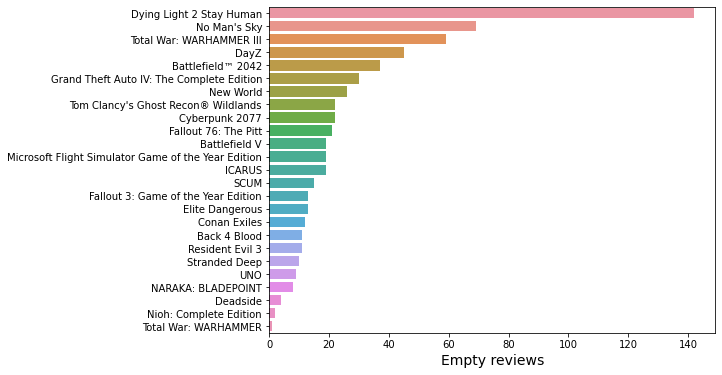

In [ ]:
# Get rows with missing reviews
data_nan = data[data['review'].isna()]

# Make a bar plot
plt.figure(figsize=(8, 6))
missing_title = data_nan['title'].value_counts()
sns.barplot(x=missing_title.values,y=missing_title.index)
plt.xlabel('Empty reviews',fontsize=14)

plt.show()

In [ ]:
# Drop rows with missing reviews
data.dropna(inplace=True)

# Sanity check
data.isna().sum()

title                 0
steam_id              0
review                0
date_posted           0
hour_played           0
votes_up              0
votes_funny           0
num_games_owned       0
num_reviews           0
recommendation        0
recommendation_int    0
dtype: int64

Next, let's check whether our dataset contains duplicated rows.

In [ ]:
data.duplicated().sum()

0

# 2. EDA

### a) Categorical and date columns

First, let's check how many games are recommended vs not recommended.

,recommendation
Recommended,72.055651
Not Recommended,27.944349


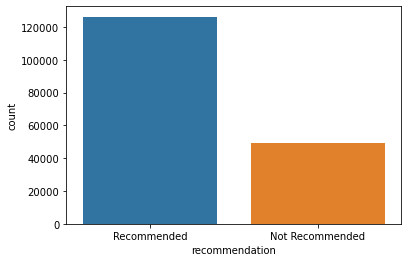

In [ ]:
# Count plot of recommendation
sns.countplot(x='recommendation',data=data)

# Count in percentage
pd.DataFrame(data['recommendation'].value_counts(normalize=True)*100)

We see that this dataset is biased towards positive reviews (72%), which is expected since most of the games in this list have overall ratings of around 70%.

Let's check the top 10 games by playtime.

Text(0, 0.5, 'Title')

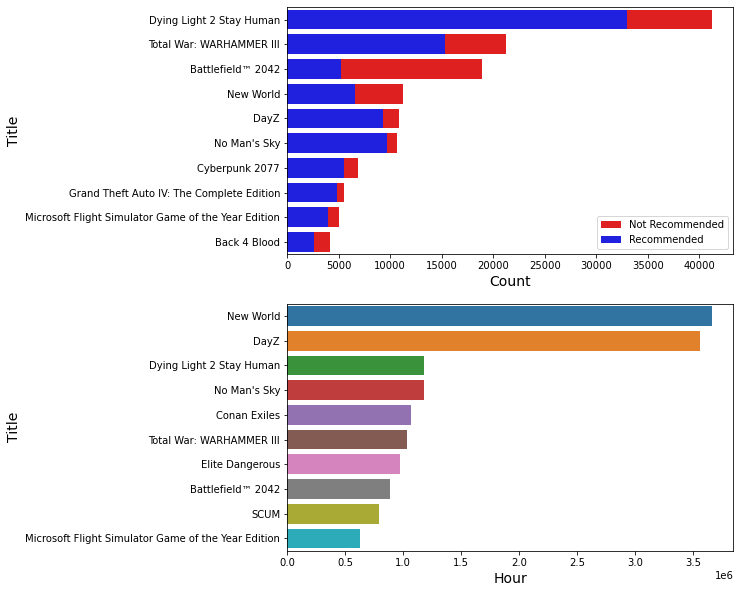

In [ ]:
# Make figure and axes objects
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(8,10))

# All reviews (positive+negative)
top_10_games_list = data['title'].value_counts().head(10).index
all_ = data[data['title'].isin(top_10_games_list)].groupby(by='title').size()
# Positive reviews
pos_ = data[(data['title'].isin(top_10_games_list)) & (data['recommendation']=="Recommended")].groupby(by='title').size()
# Combine the count of all reviews and positive reviews in a single dataframe
both_ = pd.DataFrame([all_, pos_], index=['neg', 'pos']).T.sort_values(by='neg', ascending=False)
# Plot the positive reviews on top of all reviews
sns.barplot(y=both_.index, x=both_['neg'], ax=ax[0], color='red', label='Not Recommended')
sns.barplot(y=both_.index, x=both_['pos'], ax=ax[0], color='blue', label='Recommended')
ax[0].set_xlabel('Count', fontsize=14)
ax[0].set_ylabel('Title',fontsize=14)
ax[0].legend()

# Barplot for most played games
top10_game_hour = data.groupby('title').agg(hour=('hour_played','sum')).sort_values(by='hour',ascending=False).head(10)
sns.barplot(y=top10_game_hour.index,x=top10_game_hour.hour,ax=ax[1])
ax[1].set_xlabel('Hour',fontsize=14)
ax[1].set_ylabel('Title',fontsize=14)

Among the most reviewed games in 2022, Dying Light 2, WARHAMMER III, and Battlefield 2042 are the most reviewed, which makes sense since they were released recently. We can also see that in terms of the ratio between the positive reviews to the total reviews, Battlefield 2042 seems to be the worst and No Man's Sky seems to be the best.

Let's check how many reviews are posted each day.

Text(0, 0.5, 'Review count')

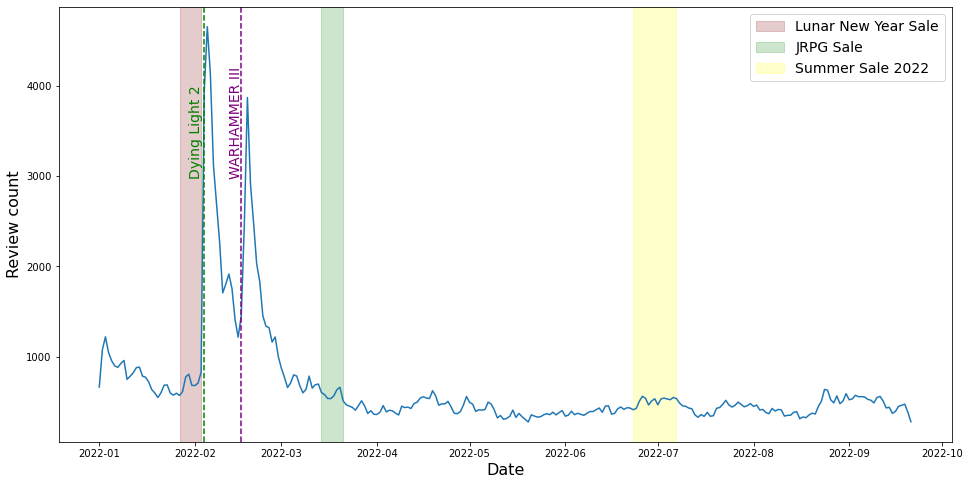

In [ ]:
# Count reviews based on date posted
review_date = data.groupby(by='date_posted').agg(count=('date_posted','count'))
date = review_date.index
count = review_date.values

# Steam events (event name, starting date, ending date, color for the plot)
steam_events = [("Lunar New Year Sale", "2022-01-27", "2022-02-03", "maroon"),
                ("JRPG Sale", "2022-03-14", "2022-03-21", "green"),
                ("Summer Sale 2022", "2022-06-23", "2022-07-07", "yellow")]

# Release dates (game name, release date, color for the plot, x offset, y position)
release_dates = [("Dying Light 2", "2022-02-04", "green", 5, 3000),
                 ("WARHAMMER III", "2022-02-16", "purple", 4, 3000)]

# Create figure
plt.figure(figsize=(16,8))

# Plot total review each day
plt.plot(date,count)

# Plot Steam events
for event in steam_events:
    plt.axvspan(np.datetime64(event[1]), np.datetime64(event[2]), alpha=0.2, color=event[3], label=event[0])

# Plot release dates and the corresponding game name
for release_date in release_dates:
    plt.axvline(x=np.datetime64(release_date[1]),ls='--',color=release_date[2])
    plt.text(np.datetime64(release_date[1])-release_date[3],release_date[4],release_date[0],fontsize=14,rotation='vertical',color=release_date[2])

# Legend, axis labels, ticks
plt.legend(fontsize=14)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Review count',fontsize=16)

It seems like the two most prominent spikes correlate with the release of the two best-selling games of 2022 so far.

Now, let's see the reviews for each of these top 6 games by date, the official release dates, and the Steam sales.

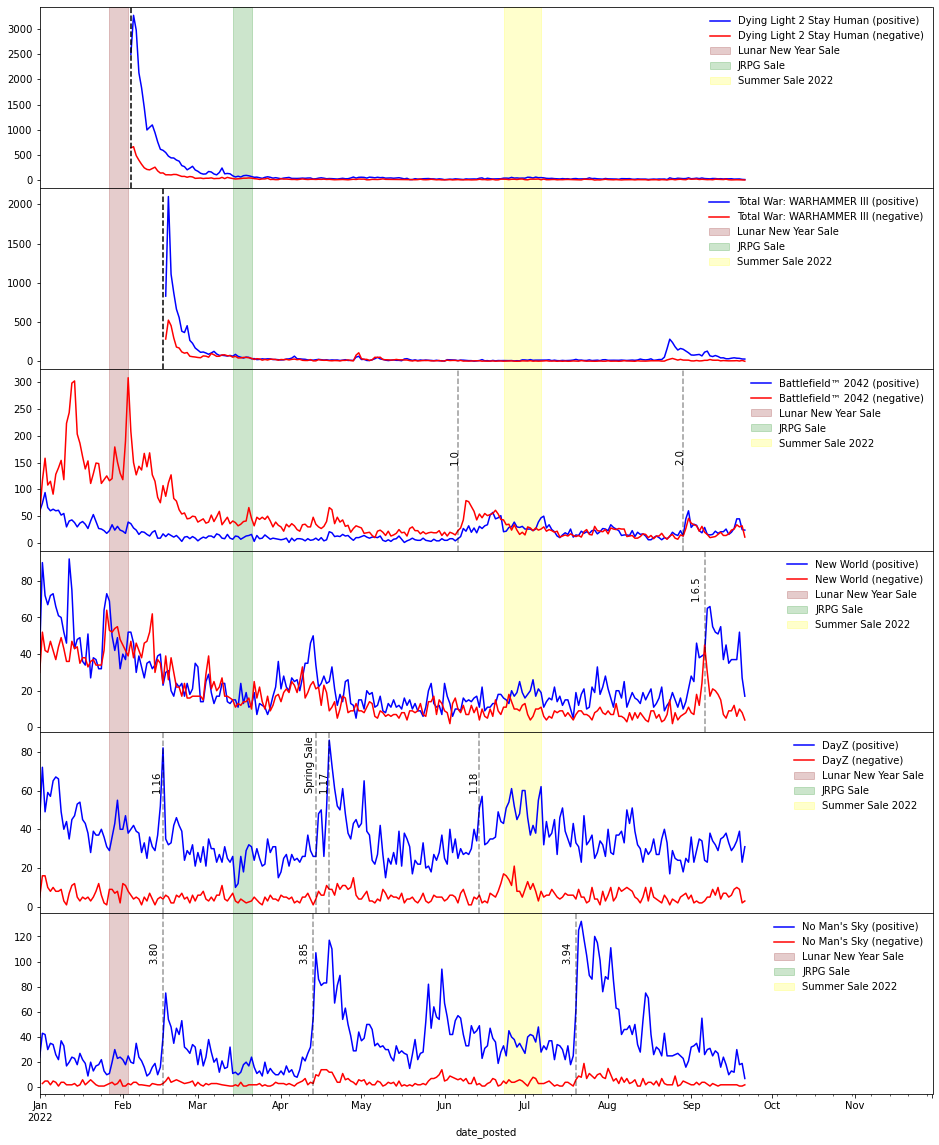

In [ ]:
# Top 6 game (sorted by early release date)
top6_game = data['title'].value_counts().head(6).index

# Create figure and axis objects
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6,ncols=1,sharex=True,figsize=(16,20))

# Color for the plot
color_list = ['blue','purple','green','red','orange','violet']

# Plot review count
# See just the total review count or divide the positive and negative review counts
divide_classes = True
for i, ax in enumerate(fig.axes):
    if not divide_classes:
        data[data['title']==top6_game[i]].groupby('date_posted')['review'].count().plot(ax=ax,label=top6_game[i],color=color_list[i])
    else:
        data[(data['title']==top6_game[i]) & (data['recommendation_int']==0)].groupby('date_posted')['review'].count().plot(ax=ax,label=top6_game[i]+' (positive)',color='blue')
        data[(data['title']==top6_game[i]) & (data['recommendation_int']==1)].groupby('date_posted')['review'].count().plot(ax=ax,label=top6_game[i]+' (negative)',color='red')
    
    # Plot Steam events
    for event in steam_events:
        ax.axvspan(np.datetime64(event[1]), np.datetime64(event[2]), alpha=0.2, color=event[3], label=event[0])
    ax.legend(loc='upper right',fontsize=10,frameon=False)

# Plot game release date
for (i, release_date) in enumerate(release_dates):
    ax = fig.axes[i]
    ax.axvline(x=np.datetime64(release_date[1]),ls='--',color='k')

# Update patch for some of the games (update name, date)
# Battlefield
update_bf = [("1.0", "2022-06-06"),
             ("2.0", "2022-08-29")]
for update in update_bf:
    ax = fig.axes[2]
    ax.axvline(x=np.datetime64(update[1]), ls='--', alpha=0.4, color='k')
    ax.text(np.datetime64(update[1])-3, 150, update[0],fontsize=10,rotation='vertical',color='k')

# New World
update_nw = [("1.6.5", "2022-09-06")]
for update in update_nw:
    ax = fig.axes[3]
    ax.axvline(x=np.datetime64(update[1]), ls='--', alpha=0.4, color='k')
    ax.text(np.datetime64(update[1])-5, 70, update[0],fontsize=10,rotation='vertical',color='k')

# DayZ
update_dayz = [("1.16", "2022-02-16"),
               ("Spring Sale", "2022-04-14"), 
               ("1.17", "2022-04-19"),
               ("1.18", "2022-06-14")]
for update in update_dayz:
    ax = fig.axes[4]
    ax.axvline(x=np.datetime64(update[1]), ls='--', alpha=0.4, color='k')
    ax.text(np.datetime64(update[1])-4, 60, update[0],fontsize=10,rotation='vertical',color='k')

# No Man's Sky
update_nms = [("3.80", "2022-02-16"),
              ("3.85", "2022-04-13"),
              ("3.94", "2022-07-20")]
for update in update_nms:
    ax = fig.axes[5]
    ax.axvline(x=np.datetime64(update[1]), ls='--', alpha=0.4, color='k')
    ax.text(np.datetime64(update[1])-5, 100, update[0],fontsize=10,rotation='vertical',color='k')

plt.xlim(right=np.datetime64("2022-11-30"))
plt.subplots_adjust(hspace=0)

### b) Numerical columns

Let's create a column containing the length of the review. This is a common step in text analysis, since the length of a text may correlate with the target variable.

In [ ]:
# Length of characters in the review
data['length'] = data['review'].apply(len)

data.head()

,title,steam_id,review,date_posted,hour_played,votes_up,votes_funny,num_games_owned,num_reviews,recommendation,recommendation_int,length
0,Microsoft Flight Simulator Game of the Year Ed...,76561198876197793,YES!,2022-01-01,25,0,0,28,10,Recommended,0,4
1,ICARUS,76561198007107695,"If you like crafting survival games, Icarus is...",2022-01-01,57,0,0,1290,1,Recommended,0,156
2,New World,76561198103334117,"officially addicted, I love this game. I wish ...",2022-01-01,253,0,0,220,2,Recommended,0,402
3,Back 4 Blood,76561198124243445,"Game should be $5, I could make a more grindab...",2022-01-01,11,8,1,55,9,Not Recommended,1,64
4,Cyberpunk 2077,76561198355294063,I feel like since this game had a terrible lau...,2022-01-01,14,1,0,101,22,Recommended,0,300


Let's check the summary statistics for the numerical columns, i.e. `funny`, `helpful`, `hour_played`, and `length`.

In [ ]:
# summary statistics
num_cols = ['num_games_owned', 'num_reviews', 'votes_funny', 'votes_up', 'hour_played', 'length']
data[num_cols].describe()

,num_games_owned,num_reviews,votes_funny,votes_up,hour_played,length
count,175234.000000,175234.000000,175234.000000,175234.000000,175234.000000,175234.000000
mean,136.937529,11.752708,0.693387,3.095119,101.536431,262.593133
std,235.516449,32.184589,27.445861,62.612750,313.939792,606.295354
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,29.000000,2.000000,0.000000,0.000000,10.000000,18.000000
50%,71.000000,5.000000,0.000000,0.000000,28.000000,69.000000
75%,162.000000,12.000000,0.000000,1.000000,70.000000,239.000000
max,19866.000000,7851.000000,8791.000000,12258.000000,16846.000000,8000.000000


We can see that most of the funny and helpful ratings are 0 or empty, up to the 75th percentile, which makes sense since most reviews should go unnoticed by the community. 

Looking at the maximum values, some of them are surprisingly high. One of the author owns 19866 games, and the most played game among the review has 16846 hours worth of playtime. Let's check the records that contain the maximum values of each feature.

In [ ]:
# Most numbers of owned games
display(data[data['num_games_owned']==max(data['num_games_owned'])])

# Author with the most reviews
display(data[data['num_reviews']==max(data['num_reviews'])])

# Funniest review
display(data[data['votes_funny']==max(data['votes_funny'])])
print(data[data['votes_funny']==max(data['votes_funny'])]['review'].values[0], '\n')

# Most helpful review
display(data[data['votes_funny']==max(data['votes_funny'])])
print(data[data['votes_up']==max(data['votes_up'])]['review'].values[0], '\n')

# Highest playtime
display(data[data['hour_played']==max(data['hour_played'])])

# Longest review
display(data[data['length']==max(data['length'])])
print(data[data['length']==max(data['length'])]['review'].values[0], '\n')

,title,steam_id,review,date_posted,hour_played,votes_up,votes_funny,num_games_owned,num_reviews,recommendation,recommendation_int,length
44539,Dying Light 2 Stay Human,76561197995008105,There were better names for this game:\n\n1.) ...,2022-02-08,0,7,3,19866,23,Not Recommended,1,1496


,title,steam_id,review,date_posted,hour_played,votes_up,votes_funny,num_games_owned,num_reviews,recommendation,recommendation_int,length
129932,New World,76561198030784015,New World is a high budget MMORPG with a uniqu...,2022-06-12,8,1,5,6747,7851,Recommended,0,1219


,title,steam_id,review,date_posted,hour_played,votes_up,votes_funny,num_games_owned,num_reviews,recommendation,recommendation_int,length
10060,Battlefield™ 2042,76561198053108226,I'd rather buy WinRAR,2022-01-11,10,12258,8791,511,1,Not Recommended,1,21


I'd rather buy WinRAR 



,title,steam_id,review,date_posted,hour_played,votes_up,votes_funny,num_games_owned,num_reviews,recommendation,recommendation_int,length
10060,Battlefield™ 2042,76561198053108226,I'd rather buy WinRAR,2022-01-11,10,12258,8791,511,1,Not Recommended,1,21


I'd rather buy WinRAR 



,title,steam_id,review,date_posted,hour_played,votes_up,votes_funny,num_games_owned,num_reviews,recommendation,recommendation_int,length
9685,Conan Exiles,76561198805704437,As shown by time played I really enjoy this ga...,2022-01-11,16846,0,0,29,1,Recommended,0,131


,title,steam_id,review,date_posted,hour_played,votes_up,votes_funny,num_games_owned,num_reviews,recommendation,recommendation_int,length
5945,SCUM,76561198079962989,[h1] Introduction [/h1]\nI cannot recommend th...,2022-01-07,58,90,10,198,25,Not Recommended,1,8000
9877,Nioh: Complete Edition,76561197981638563,[h1]“YOU AND YOUR FRIENDS ARE DEAD.\nGAME OVER...,2022-01-11,20,7,0,3847,495,Recommended,0,8000
16697,Stranded Deep,76561198325747868,WORSHIP THE CRAB ALL HAIL THE CRAB WORSHIP THE...,2022-01-20,192,69,101,50,2,Recommended,0,8000
25173,Battlefield™ 2042,76561198411835767,Refund Refund Refund Refund Refund Refund Refu...,2022-02-02,110,3,1,38,6,Not Recommended,1,8000
40890,Dying Light 2 Stay Human,76561198160904270,TLDR -I ran my word count down oops\nNON SPOIL...,2022-02-07,33,0,0,705,116,Recommended,0,8000
41152,Dying Light 2 Stay Human,76561198159385322,Zombie go brrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr...,2022-02-07,8,0,0,70,4,Recommended,0,8000
41361,Dying Light 2 Stay Human,76561198060758555,"If you're buying this game for story, expectin...",2022-02-07,35,2,0,137,6,Not Recommended,1,8000
51458,Dying Light 2 Stay Human,76561197996972442,I played this game on KB+M and this review wil...,2022-02-12,53,0,0,690,54,Not Recommended,1,8000
52779,Dying Light 2 Stay Human,76561198063656273,I LOVED dying light 1.. played through every c...,2022-02-13,13,0,1,133,8,Not Recommended,1,8000
67327,Total War: WARHAMMER III,76561198101253848,"POSTED: 18 FEBRUARY\nRemove denuvo, so that pl...",2022-02-19,10,7,0,1204,35,Recommended,0,8000


[h1] Introduction [/h1]
I cannot recommend this game for everyone. But I will recommend it for some.
I'll try and explain this briefly
So here's the thing, if you aren't into survival games, you probably wouldn't even be reading this review, but if you aren't familiar with survival games, you should probably go look into other games than this one not to scare you off, I recommend something easy to get to know like Rust. 
Now, to explain this to everyone else who don't know what the game is about, basically it's survival games taken to the "extreme" to be short. You have an excessive amount of options for maintaining your body and health. This includes vitamins, extensive cold/heat system and an very well done but also advanced weight system. I'll explain everything further in this review if this sounds interesting to you or if you're just bored. 
So lets start off with the positive(these could also be seen as negatives, depending on how much you're into survival games)

[h1] Pros [/h1]

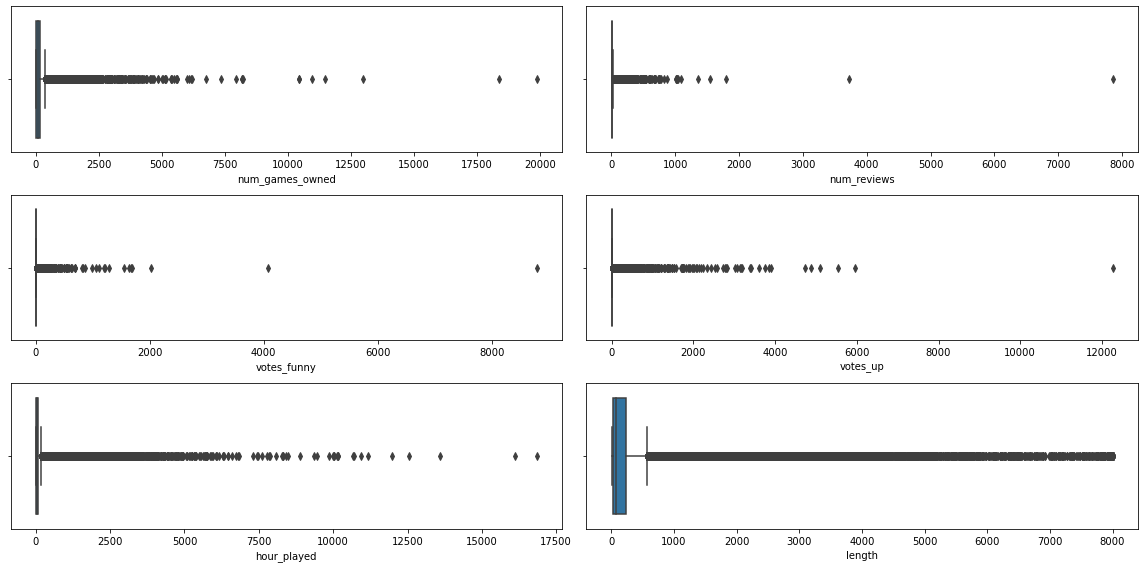

In [ ]:
# Check the distribution for these numerical columns
# Create boxplot
plt.figure(figsize=(16,8))
for i, col in enumerate(num_cols):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=col,data=data)
    plt.tight_layout()

Just to make the visualization easier, we will transform them to log units (using log1p function to avoid log(0))

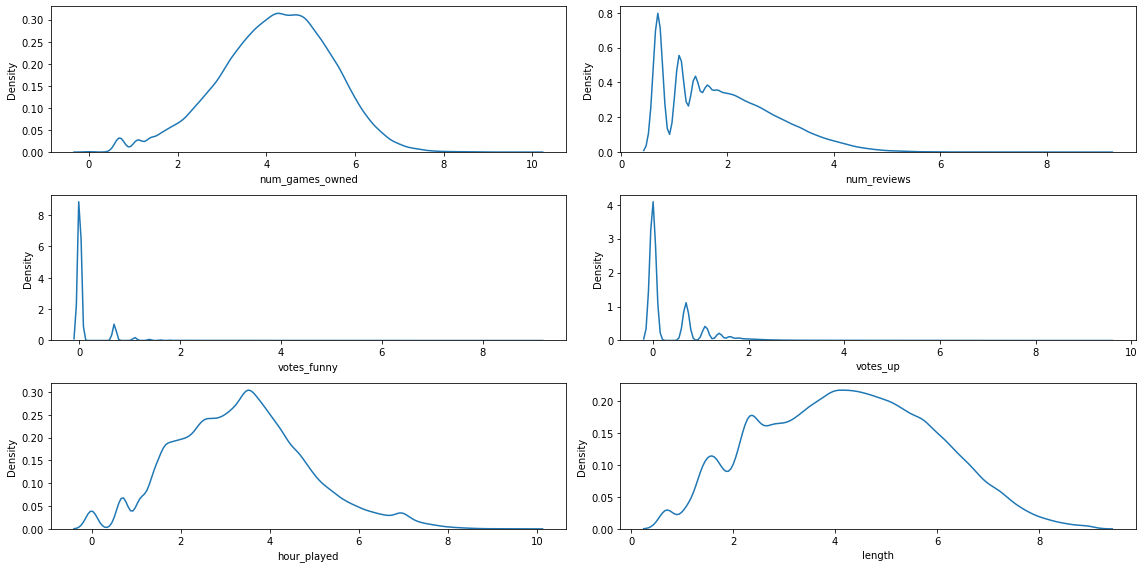

In [ ]:
# Take log of numerical columns
data_num_log = np.log1p(data[num_cols])

# Plot review length distribution
plt.figure(figsize=(16,8))
for i, col in enumerate(num_cols):
    plt.subplot(3,2,i+1)
    sns.kdeplot(x=col,data=data_num_log)
    plt.tight_layout()

Let's check if there are any correlation between each pair of the numerical features.

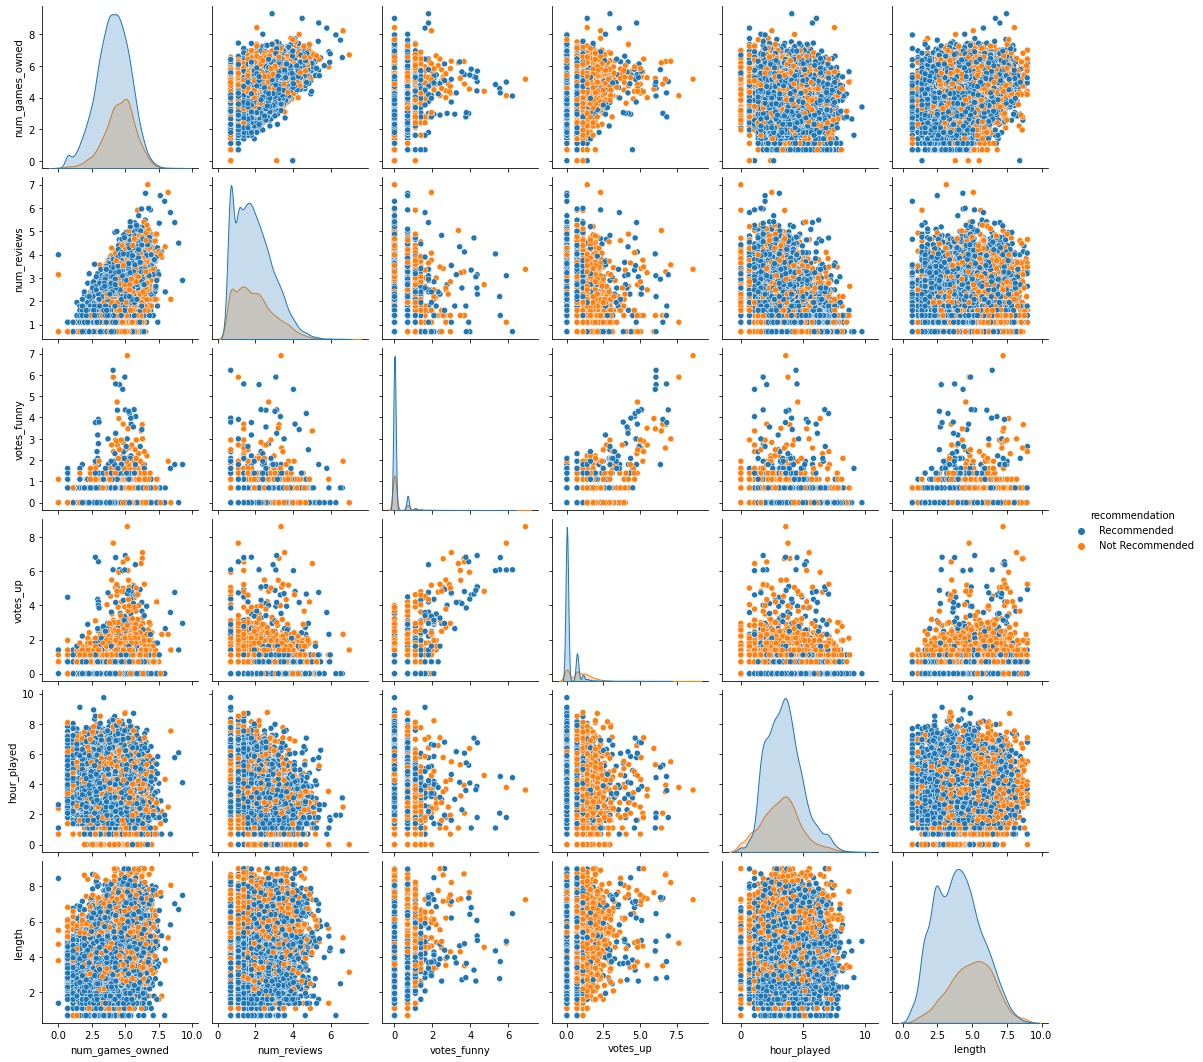

In [ ]:
# Create pairplot for numerical columns
data_num_log = data_num_log.merge(data['recommendation'], left_index=True, right_index=True).sample(10000)
sns.pairplot(data_num_log, hue='recommendation')

There seems to be positive correlations between the helpfulness (`votes_up`) and the funniness (`votes_funny`) of a review, and maybe between the number of games owned and the number of reviews the author has written. Other than that, these features do not seem to correlate with each other, nor the histograms show any dependency with `recommendation`.

### c) Word Cloud

Let's make a word cloud for the entire dataset.

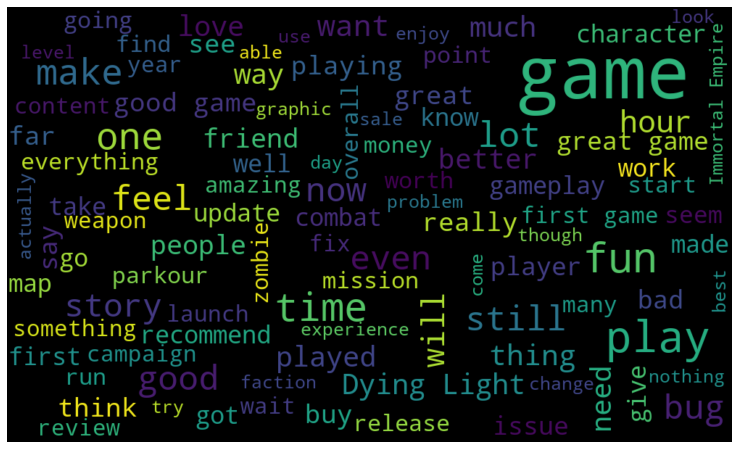

In [ ]:
from wordcloud import WordCloud

def create_wordcloud(data, col_name, cm):
    txt = ' '.join(rev for rev in data[col_name])
    plt.figure(figsize=(15,8))

    wordcloud = WordCloud(
                background_color = 'black',
                max_font_size = 100,
                max_words = 100,
                width = 1000,
                height = 600,
                colormap=cm
                ).generate(txt)


    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    return

create_wordcloud(data, 'review', 'viridis')

Now, let's make a word cloud for the positive review (recommended games).

In [ ]:
create_wordcloud(data[data['recommendation']=='Recommended'],'Greens')

We can see that the most common words are 'love', 'great', 'enjoy', 'fun' etc. They all convey positive emotions.

Finally, let's create a word cloud for the negative reviews (not recommended).

In [ ]:
create_wordcloud(data[data['recommendation']=='Not Recommended'],'Reds')

We can see that the most common words are 'boring', 'bug', 'fix', and 'problem'. They all convey negative emotions.

# 3. Rule-Based Classification

As the first step, we will try to classify the sentiments using an unsupervised method, or specifically a rule-based method. We will do this with Textblob and VADER. We will also treat the threshold value of the two sentiments as a hyperparameter and tune it to get the best result possible. Since we do not need to train the model, we can balance the classes beforehands so that our results is easier to interpret (and we can simply use the accuracy score).

In [ ]:
# Undersampling the majority class so the evaluation is more objective
df_pos = data[data['recommendation_int']==0]
df_neg = data[data['recommendation_int']==1]
df_pos_under = df_pos.sample(n=len(df_neg), random_state=42)

df_unsupervised = pd.concat([df_pos_under, df_neg]).sample(frac=1, random_state=42)

## 3.1. Unsupervised sentiment analysis with Textblob

In [ ]:
# Import some evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [ ]:
# Define the function to get polarity score from textBlob
from textblob import TextBlob
# Get the polarity score using below function
def textblob_score(doc):
    # This polarity score is between -1 to 1
    polarity = TextBlob(doc).sentiment.polarity
    return polarity

# Obtain the "textblob score"
df_unsupervised['textblob_score'] = df_unsupervised['review'].apply(textblob_score)

Now let's plot the accuracy score across different values of the threshold.

In [ ]:
# Array of thresholds to be tested
thresh_ = np.linspace(-1., 1., 2000)

acc_score_ = []
y_true = df_unsupervised['recommendation_int']

for thresh in thresh_:
    y_pred = df_unsupervised['textblob_score'].apply(lambda x: 0 if x>=thresh else 1)
    acc_score_.append(accuracy_score(y_true, y_pred))

Optimal threshold = -0.0005002501250626068 with an accuracy of 72.0%
Confusion matrix: 

[[41282  7686]
 [20214 28754]] 

              precision    recall  f1-score   support

           0       0.67      0.84      0.75     48968
           1       0.79      0.59      0.67     48968

    accuracy                           0.72     97936
   macro avg       0.73      0.72      0.71     97936
weighted avg       0.73      0.72      0.71     97936



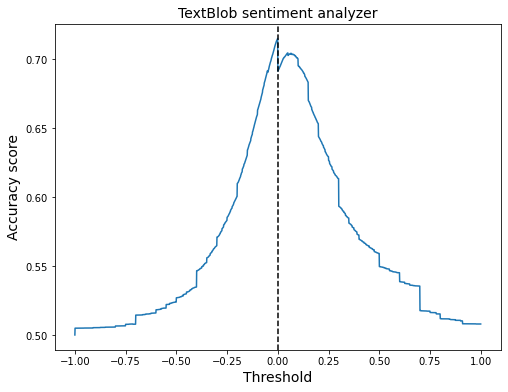

In [ ]:
# Plot accuracy score vs threshold
plt.figure(figsize=(8,6))
plt.plot(thresh_, acc_score_)
plt.title("TextBlob sentiment analyzer", fontsize=14)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Accuracy score', fontsize=14)

# Plot vertical line at maximum value
best_thresh = thresh_[np.argmax(acc_score_)]
plt.axvline(x=best_thresh, ls='--', color='k')
print(f"Optimal threshold = {best_thresh} with an accuracy of {round(max(acc_score_), 2)*100}%")

# Print the confusion matrix using the best threshold
y_pred_best = df_unsupervised['textblob_score'].apply(lambda x: 0 if x>=best_thresh else 1)
print("Confusion matrix: \n")
print(confusion_matrix(y_true, y_pred_best), '\n')
print(classification_report(y_true, y_pred_best))

Let's do the same thing, this time using VADER.

## 3.2. Unsupervised sentiment analysis with VADER

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

def vader_score(doc):
    score = analyser.polarity_scores(doc)
    return score['compound']

# Obtain the "vader score"
df_unsupervised['vader_score'] = df_unsupervised['review'].apply(vader_score)

In [ ]:
# Array of thresholds to be tested
thresh_ = np.linspace(-1., 1., 2000)

acc_score_ = []
y_true = df_unsupervised['recommendation_int']

for thresh in thresh_:
    y_pred = df_unsupervised['vader_score'].apply(lambda x: 0 if x>=thresh else 1)
    acc_score_.append(accuracy_score(y_true, y_pred))

Optimal threshold = -0.0005002501250626068 with an accuracy of 72.0%
Confusion matrix: 

[[44235  4733]
 [22912 26056]] 

              precision    recall  f1-score   support

           0       0.66      0.90      0.76     48968
           1       0.85      0.53      0.65     48968

    accuracy                           0.72     97936
   macro avg       0.75      0.72      0.71     97936
weighted avg       0.75      0.72      0.71     97936



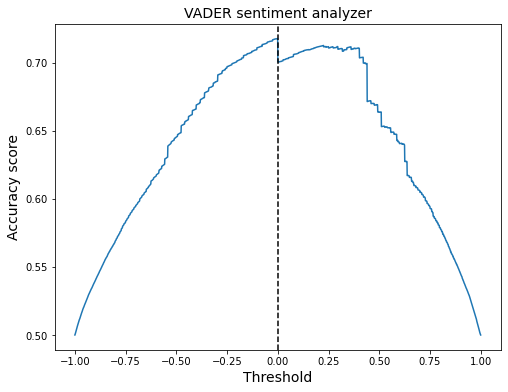

In [ ]:
# Plot accuracy score vs threshold
plt.figure(figsize=(8,6))
plt.plot(thresh_, acc_score_)
plt.title("VADER sentiment analyzer", fontsize=14)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Accuracy score', fontsize=14)

# Plot vertical line at maximum value
best_thresh = thresh_[np.argmax(acc_score_)]
plt.axvline(x=best_thresh, ls='--', color='k')
print(f"Optimal threshold = {best_thresh} with an accuracy of {round(max(acc_score_), 2)*100}%")

# Print the confusion matrix using the best threshold
y_pred_best = df_unsupervised['vader_score'].apply(lambda x: 0 if x>=best_thresh else 1)
print("Confusion matrix: \n")
print(confusion_matrix(y_true, y_pred_best), '\n')
print(classification_report(y_true, y_pred_best))

# 4. Text Processing

This is where the real work begin. Basically, we want to convert these reviews into something that can be understood by the machine, i.e. numbers. However, we will not be using the entire dataset, because it will take too much time. I will only use reviews posted in the year 2019. For the most part, we will use regular expression and the `nltk` library to process the reviews.

In [ ]:
# Import relevant libraries
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Define the function to clean the text
def text_cleaning(text):
    
    # Remove links
    text = re.sub(r'http\S+', '', text)
    
    # Remove hyperlinks and markups
    text = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', text)
    text = re.sub('&gt;', "", text)
    text = re.sub('&#x27;', "'", text)
    text = re.sub('&quot;', '"', text)
    text = re.sub('&#x2F;', ' ', text)
    text = re.sub('<p>', ' ', text)
    text = re.sub('</i>', '', text)
    text = re.sub('&#62;', '', text)
    text = re.sub('<i>', ' ', text)
    text = re.sub("\n", ' ', text)
    
    # Unify whitespaces
    text = re.sub(' +', ' ', text)
    
    # Remove non-alphabetic characters
    text = re.sub(r"[^a-zA-Z?!.,]+", ' ', text)
    
    # Remove punctuation, convert to lowercase
    nopunc = [char.lower() for char in text if char not in punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Remove stop words
    text = nopunc.split()
    no_stopword = [word for word in text if word not in (stopwords.words('english'))]
    
    # Stemming
    snowball_stemmer = SnowballStemmer('english')
    stemmed_word = [snowball_stemmer.stem(word) for word in no_stopword]
    stem = ' '.join(stemmed_word)
    
    # Remove nonsensical words (troll messages) defined as having more than 5 consecutive consonants
    text = re.sub(r'\w*[^aeiouAEIOU\W]{5}\w*', '', stem)
    
    # Check if text is empty after cleaning
    if text=='':
        return np.nan
    else:
        return text

Let's apply this function to our document.

In [ ]:
data['clean_review'] = data['review'].apply(text_cleaning)

In [ ]:
for i in range(3):
    print(f"Original review: \n {data.loc[i, 'review']} \n")
    print(f"Cleaned review: \n {data.loc[i, 'clean_review']} \n")

Original review: 
 YES! 

Cleaned review: 
 yes 

Original review: 
 If you like crafting survival games, Icarus is a good unforgiving survival game to try! You will learn to fear the storms when all you have is a thatch hut. 

Cleaned review: 
 like craft surviv game icarus good unforgiv surviv game tri learn fear storm thatch hut 

Original review: 
 officially addicted, I love this game. I wish it was also on Mac so I didn't have to use my more limited boot camp space but oh well thats why i have boot camp!  For Mac users, I am running it on a 2019 16" Macbook pro, with 2.4GHZ 8core i9 and 32 gb ram with a AMD Radeon Pro 5600M 8 GB graphics card and dedicating 1TB space to windows 10......The graphics are awesome and i experience no lag at all. 

Cleaned review: 
 offici addict love game wish also mac use limit boot camp space oh well that boot camp mac user run macbook pro ghz core gb ram amd radeon pro gb graphic card dedic tb space window graphic awesom experi lag 



There could be cases where the reviews are completely empty after cleaning, e.g. if the review only contains nonalphabetical characters. We shall remove these completely as they are useless for analysis.

In [ ]:
# Check rows with empty cleaned reviews
data[data.isna().any(axis=1)]

,title,steam_id,review,date_posted,hour_played,votes_up,votes_funny,num_games_owned,num_reviews,recommendation,recommendation_int,clean_review
53,ICARUS,76561199223500936,:),2022-01-01,73,0,0,46,1,Recommended,0,NaN
113,Grand Theft Auto IV: The Complete Edition,76561198080674365,ＦＵＣＫ ＹＯＵ ＲＯＣＫＳＴＡＲ\n................./¯/).........,2022-01-01,9,4,1,326,36,Not Recommended,1,NaN
206,DayZ,76561199085824646,O_O,2022-01-01,15,0,0,24,13,Recommended,0,NaN
233,ICARUS,76561198121381734,no just no,2022-01-01,6,1,0,129,2,Not Recommended,1,NaN
253,DayZ,76561199115846012,100,2022-01-01,1010,0,0,17,2,Recommended,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
175735,Deadside,76561198444876392,is,2022-09-21,29,0,0,51,8,Recommended,0,NaN
175752,Battlefield V,76561198327850281,WWWWWWWWWWW,2022-09-21,10,0,0,41,19,Recommended,0,NaN
175764,No Man's Sky,76561198999698091,:D,2022-09-21,46,0,0,11,1,Recommended,0,NaN
175765,DayZ,76561198051141539,m,2022-09-21,106,0,0,26,1,Recommended,0,NaN


So we have 4288 records that return empty reviews after cleaning. The original reviews are either stop words, special characters, or emojis. We shall drop these records completely.

In [ ]:
# Drop empty reviews
data.dropna(inplace=True)

# Sanity check
data.isna().sum()

title                 0
steam_id              0
review                0
date_posted           0
hour_played           0
votes_up              0
votes_funny           0
num_games_owned       0
num_reviews           0
recommendation        0
recommendation_int    0
clean_review          0
dtype: int64

## 5.1. Word Cloud (Again)

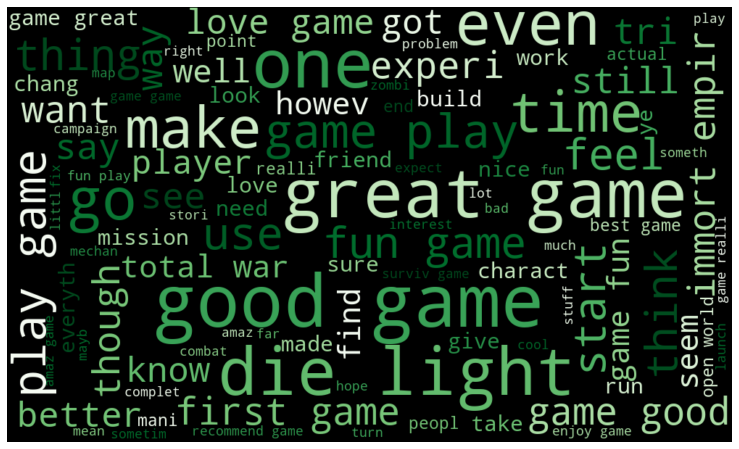

In [ ]:
# For positive reviews
create_wordcloud(data[data['recommendation']=='Recommended'], 'clean_review', 'Greens')

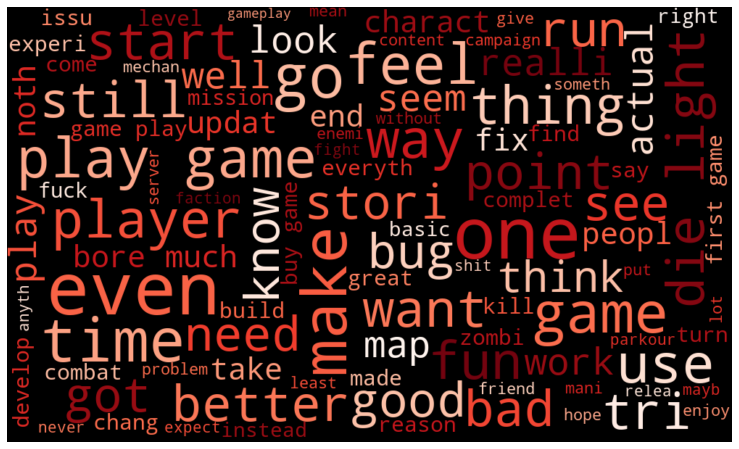

In [ ]:
# For negative reviews
create_wordcloud(data[data['recommendation']=='Not Recommended'], 'clean_review', 'Reds')

In [ ]:
from collections import Counter

# Check the most frequent word
review_vis2 = data.copy()
review_vis2['temp_list'] = review_vis2['clean_review'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(data=[top.keys(),top.values()]).T
temp.columns = ['Common_words','count']
temp.sort_values(by='count',ascending=False).head(10).reset_index(drop=True)

,Common_words,count
0,game,223054
1,play,60651
2,like,48501
3,good,42524
4,get,39839
5,fun,35382
6,time,33219
7,one,26190
8,realli,23447
9,great,23158


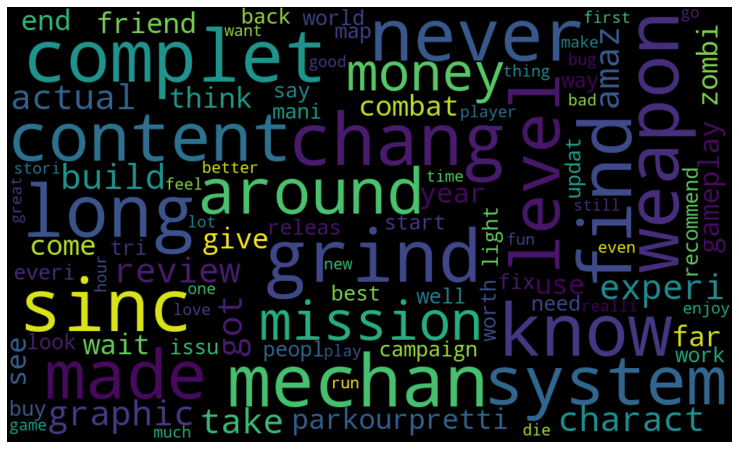

In [ ]:
# Word cloud for top words
# create_wordcloud(df, 'clean_review', 'viridis')
create_wordcloud(temp.rename(columns={'Common_words':'review'}).sort_values(by='count').tail(100), 'review', 'viridis')

Therefore 'fun', 'good', and 'like' are the most common words in our document, which is expected since most of the reviews are positive.

In [ ]:
# Save the cleaned review
data.to_csv("data/review_cleaned.csv", index=False)

# 6. Data Sampling

We used the whole dataset for exploration, but we will only use a subset of the whole records to reduce the computation time. Feel free to try and run the following steps with the whole dataset if your machine can handle it.

We will randomly sample 10% of records from the original dataset for further analysis. We can use the remaining 90% to test the performance of our model.

,recommendation
Recommended,71.779572
Not Recommended,28.220428


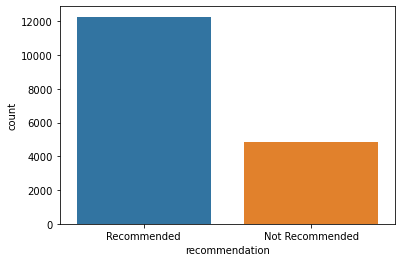

In [ ]:
# Use sklearn's train_test_split
from sklearn.model_selection import train_test_split

# Sample 10% of the whole dataset and save it
df_used, df_unused = train_test_split(data, train_size=0.1, random_state=42)

# Check the balancedness
sns.countplot(x='recommendation',data=df_used)
display(pd.DataFrame(df_used['recommendation'].value_counts(normalize=True)*100))

# Save to new files
df_used.to_csv('data/for_analysis.csv', index=False)
df_unused.to_csv('data/not_used.csv', index=False)

The class ratio is consistent with the original dataset.

# 7. Model Building: Bag of Words/Count Vector

We have cleaned the reviews. Now, it's time to vectorize the reviews and create a model to predict whether a review conveys a positive or a negative sentiment.

In [59]:
# Doing this from google drive so we can use GPU for faster computation
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Install packages
# !pip install hyperopt
# !pip install lightgbm

In [61]:
# Open the file
path = 'drive/MyDrive/Colab Notebooks/steam_reviews_2.0/data/for_analysis.csv'
df = pd.read_csv(path)

In [62]:
# Train-test split
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [285]:
# Import text vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Import classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
# Import pipeline
from sklearn.pipeline import Pipeline
# ROC curve and PR curve
from sklearn.metrics import roc_curve, precision_recall_curve
# Import grid search, randomized search, and stratified folding
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
# Import hyperopt for Bayesian search
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
# For model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
# To copy an object
from copy import copy, deepcopy

# Function to print evaluation metric
def model_evaluation(name, y_test, y_pred):
    round_result = 3
    print(f'Model: {name}','\n')
    cm = confusion_matrix(y_test,y_pred)
    print('Confusion matrix: \n', cm,'\n')
    print('Classification report: \n',classification_report(y_test,y_pred))
    print("\n")
    print(f'TN - True Positive: {cm[1,1]}')
    print(f'FP - False Negative: {cm[1,0]}')
    print(f'FN - False Positive: {cm[0,1]}')
    print(f'TP - True Negative: {cm[0,0]}')
    print(f'Accuracy Rate: {round(accuracy_score(y_test,y_pred),round_result)*100}%')
    print(f'Misclassification Rate: {round(1-accuracy_score(y_test,y_pred),round_result)*100}%')
    print(f'Recall: {round(recall_score(y_test,y_pred),round_result)}')
    print(f'Precision: {round(precision_score(y_test,y_pred),round_result)}')
    print(f'F1-Score: {round(f1_score(y_test,y_pred),round_result)}')
    print(f'ROC-AUC score: {round(roc_auc_score(y_test,y_pred),round_result)}')
    return

# Create a class for the machine learning model
class Model():
    
    def __init__(self, name, df, vectorizer, classifier, fixed_params={}, random_state=42, test_size=0.3):
        self.name = name
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.seed = random_state
        self.fixed_params = fixed_params
        self.fixed_params['random_state'] = random_state
        
        # split the data into train and test data by test_size:1-test_size
        self.feature = 'clean_review'
        self.target = 'recommendation_int'
        self.X_train = df[self.feature]
        self.y_train = df[self.target]

        # Create base pipeline (no tuned hyperparameters)
        self.pipeline = Pipeline([
                                ('vec', self.vectorizer),
                                ('clf', self.classifier)
                                ])

    def train_and_evaluate(self, use_best_hp=False, k_folds=10):

        # Split the training into training-validation (cross-validation)
        skf = StratifiedKFold(n_splits=k_folds)
        X = self.X_train
        y = self.y_train

        # Use the best hyperparameters if toggled
        if not use_best_hp:
          # Generate list to store score from CV method
          self.cv_accuracy_score_base = []
          self.cv_recall_score_base = []
          self.cv_precision_score_base = []
          self.cv_f1_score_base = []
          self.cv_roc_auc_score_base = []
          # Iterate over the k-folds and save the scores
          for i, (train, valid) in enumerate(skf.split(X, y)):
              self.pipeline.fit(X.iloc[train], y.iloc[train])
              y_valid_pred = self.pipeline.predict(X.iloc[valid])
              # Append the scores
              self.cv_accuracy_score_base.append(accuracy_score(y.iloc[valid], y_valid_pred))
              self.cv_recall_score_base.append(recall_score(y.iloc[valid], y_valid_pred))
              self.cv_precision_score_base.append(precision_score(y.iloc[valid], y_valid_pred))
              self.cv_f1_score_base.append(f1_score(y.iloc[valid], y_valid_pred))
              self.cv_roc_auc_score_base.append(roc_auc_score(y.iloc[valid], y_valid_pred))

          # Print the mean value of the CV results
          print(f'Accuracy score: {round(np.mean(self.cv_accuracy_score_base)*100,3)}%')
          print(f'Recall score: {round(np.mean(self.cv_recall_score_base)*100,3)}%')
          print(f'Precision score:  {round(np.mean(self.cv_precision_score_base)*100,3)}%')
          print(f'F1 score:  {round(np.mean(self.cv_f1_score_base)*100,3)}%')
          print(f'ROC AUC score: {round(np.mean(self.cv_roc_auc_score_base),3)}')
          return
        else:
          # Add the hyperparameters to the pipeline
          # Use deep copy so the base pipeline is unchanged
          self.pipeline_hp = deepcopy(self.pipeline)
          self.pipeline_hp.set_params(**self.best_params_hp)

          # Generate list to store score from CV method
          self.cv_accuracy_score_hp = []
          self.cv_recall_score_hp = []
          self.cv_precision_score_hp = []
          self.cv_f1_score_hp = []
          self.cv_roc_auc_score_hp = []
          
          # Iterate over the k-folds and save the scores
          for i, (train, valid) in enumerate(skf.split(X, y)):
              self.pipeline_hp.fit(X.iloc[train], y.iloc[train])
              y_valid_pred = self.pipeline_hp.predict(X.iloc[valid])
              self.cv_accuracy_score_hp.append(accuracy_score(y.iloc[valid],y_valid_pred))
              self.cv_recall_score_hp.append(recall_score(y.iloc[valid],y_valid_pred))
              self.cv_precision_score_hp.append(precision_score(y.iloc[valid],y_valid_pred))
              self.cv_f1_score_hp.append(f1_score(y.iloc[valid],y_valid_pred))
              self.cv_roc_auc_score_hp.append(roc_auc_score(y.iloc[valid],y_valid_pred))
          
          # Print the mean value of the CV results
          print(f'Accuracy score: {round(np.mean(self.cv_accuracy_score_hp)*100,3)}%')
          print(f'Recall score: {round(np.mean(self.cv_recall_score_hp)*100,3)}%')
          print(f'Precision score:  {round(np.mean(self.cv_precision_score_hp)*100,3)}%')
          print(f'F1 score:  {round(np.mean(self.cv_f1_score_hp)*100,3)}%')
          print(f'ROC AUC score: {round(np.mean(self.cv_roc_auc_score_hp),3)}')
          
          return
   
    # Perform bayesian search over the hyperparameter space
    # Objective function whose loss we want to minimize
    def objective_func(self, args):
        # Initialize model pipeline by making deep copy so the base pipeline is unchanged
        pipe = deepcopy(self.pipeline)
        
        # Model parameters will be set here
        pipe.set_params(**args) 

        # Cross Validation Score
        score = cross_val_score(pipe, self.X_train, self.y_train, scoring=self.scoring, cv=5, n_jobs=-1, error_score=0.99)

        # We return 1- score to minimize it
        return {'loss': 1 - np.mean(score), 'status': STATUS_OK}
    
    # Get the best hyperparameters using Bayesian search
    def bayes_search(self, space, scoring='f1', max_evals=50):
        
        self.scoring = scoring

        # Hyperopts Trials() records all the model and run artifacts.
        trials = Trials()

        # Fmin will call the objective function with selective param set. 
        # The choice of algorithm will narrow the searchspace.
        self.best_classifier = fmin(self.objective_func, space, algo=tpe.suggest,
                               max_evals=max_evals, trials=trials, rstate=np.random.RandomState(self.seed))
        self.best_params_hp = space_eval(space, self.best_classifier)
        return
    
    # Final model evaluation
    def predict_test(self, data_test, use_best_hp=False):
        
        # Get feature and target from test data
        self.X_test = data_test[self.feature]
        self.y_test = data_test[self.target]
        
        # If hyperparameters are used, get them from bayesian search
        if use_best_hp:
          # Make predictions for test set
          self.y_pred_proba_hp = self.pipeline_hp.predict_proba(self.X_test)
          y_pred = self.pipeline_hp.predict(self.X_test)
        else:
          # Make predictions for test set
          self.y_pred_proba = self.pipeline.predict_proba(self.X_test)
          y_pred = self.pipeline.predict(self.X_test)
        
        # Print model evaluation
        model_evaluation(self.name, self.y_test, y_pred)
        return
    
    # Plot ROC curve
    def get_roc(self, color, label, use_best_hp=False):
        
        # Get false positive rate, true positive rate, and threshold
        if use_best_hp:
          fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_proba_hp[:,1])
        else:
          fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_proba[:,1])
        
        # Plot TPR vs FPR
        plt.plot(fpr, tpr, color=color, label=label)
        
        return
    
    # Plot precision-recall curve
    def get_prc(self, color, label, use_best_hp=False):
        
        # Get precision, recall, and threshold
        if use_best_hp:
          precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_proba_hp[:,1])
        else:
          precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_proba[:,1])
        
        # Plot recall vs precision
        plt.plot(recall, precision, color=color, label=label)
        # No skill classifier
        self.y_noskill = self.y_test.value_counts(normalize=True).loc[1]
        
        return

### a. BOW + Naive Bayes  (baseline model)

In [286]:
# Instantiate the model
bow_nb = Model('BOW+NB', df_train, CountVectorizer(), MultinomialNB())

In [287]:
# Train on training set and evaluate prediction on test set
bow_nb.train_and_evaluate(use_best_hp=False)

Accuracy score: 85.733%
Recall score: 66.574%
Precision score:  78.874%
F1 score:  72.171%
ROC AUC score: 0.798


### b. BOW + Logistic Regression

In [66]:
# Instantiate the model
bow_logreg = Model('BOW+LogReg', df_train, CountVectorizer(), LogisticRegression(max_iter=1000))

In [67]:
# Train on training set and evaluate prediction on test set
bow_logreg.train_and_evaluate(use_best_hp=False)

Accuracy score: 85.391%
Recall score: 62.937%
Precision score:  80.353%
F1 score:  70.528%
ROC AUC score: 0.785


### c. BOW + Stochastic Gradient Descent

In [68]:
# Instantiate the model
bow_sgdc = Model('BOW+SGDC', df_train, CountVectorizer(), SGDClassifier(loss='log', random_state=42))

In [69]:
# Train on training set and evaluate prediction on test set
bow_sgdc.train_and_evaluate(use_best_hp=False)

Accuracy score: 85.407%
Recall score: 62.847%
Precision score:  80.538%
F1 score:  70.516%
ROC AUC score: 0.785


### d. BOW + Decision Tree

In [70]:
# Instantiate the model
bow_dt = Model('BOW+DT', df_train, CountVectorizer(), DecisionTreeClassifier(random_state=42))

In [71]:
# Train on training set and evaluate prediction on test set
bow_dt.train_and_evaluate(use_best_hp=False)

Accuracy score: 78.337%
Recall score: 60.983%
Precision score:  61.079%
F1 score:  60.987%
ROC AUC score: 0.73


### Compare the models

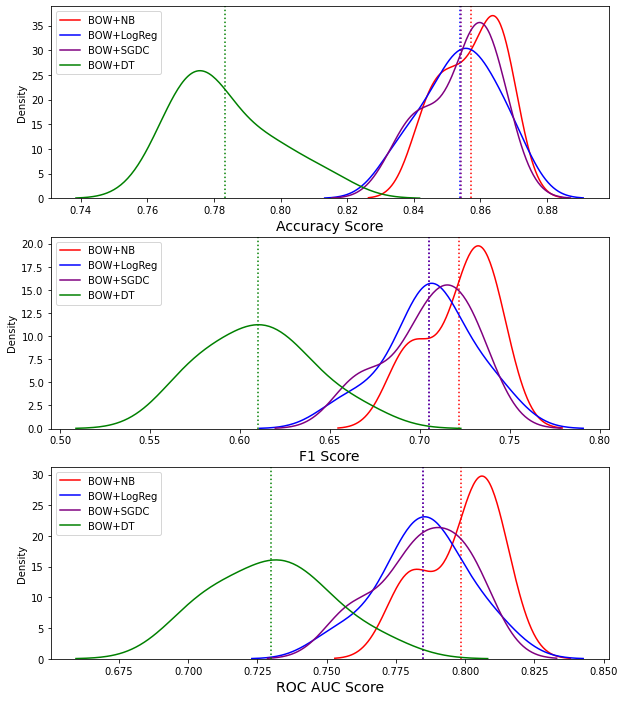

In [72]:
# List to store all models
models_bow = [bow_nb, bow_logreg, bow_sgdc, bow_dt]
colors = ['red', 'blue', 'purple', 'green', 'orange']

# Plot histogram of roc accuracy score
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))

# Iterate over all models
for i, model in enumerate(models_bow):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score_base, ax=ax1, color=colors[i], label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score_base), color=colors[i], ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy Score', fontsize=14)
    
    # Plot F1 score
    sns.kdeplot(model.cv_f1_score_base, ax=ax2, color=colors[i], label=model.name)
    ax2.axvline(x=np.mean(model.cv_f1_score_base), color=colors[i], ls=':')
    
    ax2.legend()
    ax2.set_xlabel('F1 Score', fontsize=14)

    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score_base, ax=ax3, label=model.name, color=colors[i])
    ax3.axvline(x=np.mean(model.cv_roc_auc_score_base), color=colors[i], ls=':')
    
    ax3.legend()
    ax3.set_xlabel('ROC AUC Score', fontsize=14)

It looks like our baseline model, i.e. BOW+Naive Bayes performs the best out of the other models. Let's see if we can improve these scores by using another vectorizer: TF-IDF.

# 8. Model Building: TF-IDF

We have created our baseline model using the simple bag-of-words vectorizer. Now, we will focus on the models that have the best performance, i.e. naive bayes, logistic regression, and stochastic gradient descent. We will use the TF-IDF vectorizer to see if we can improve their performance.

### a. TF-IDF + Naive Bayes

In [139]:
# Instantiate the model
tfidf_nb = Model('TF-IDF+NB', df_train, TfidfVectorizer(), MultinomialNB())

In [140]:
# Train on training set and evaluate prediction on test set
tfidf_nb.train_and_evaluate(use_best_hp=False)

Accuracy score: 79.925%
Recall score: 30.144%
Precision score:  92.695%
F1 score:  45.413%
ROC AUC score: 0.646


### b. TF-IDF + Logistic Regression

In [141]:
# Instantiate the model
tfidf_logreg = Model('TF-IDF+LogReg', df_train, TfidfVectorizer(), LogisticRegression())

In [142]:
# Train on training set and evaluate prediction on test set
tfidf_logreg.train_and_evaluate(use_best_hp=False)

Accuracy score: 86.377%
Recall score: 63.148%
Precision score:  83.922%
F1 score:  72.024%
ROC AUC score: 0.792


### c. TF-IDF + Stochastic Gradient Descent

In [300]:
# Instantiate the model
tfidf_sgdc = Model('TF-IDF+SGDC', df_train, TfidfVectorizer(), SGDClassifier(loss='log', random_state=42))

In [301]:
# Train on training set and evaluate prediction on test set
tfidf_sgdc.train_and_evaluate(use_best_hp=False)

Accuracy score: 86.402%
Recall score: 62.817%
Precision score:  84.312%
F1 score:  71.956%
ROC AUC score: 0.792


### d. TF-IDF + Decision Tree

In [145]:
# Instantiate the model
tfidf_dt = Model('TF-IDF+DT', df_train, TfidfVectorizer(), DecisionTreeClassifier(random_state=42))

In [146]:
# Train on training set and evaluate prediction on test set
tfidf_dt.train_and_evaluate(use_best_hp=False)

Accuracy score: 79.097%
Recall score: 61.072%
Precision score:  62.748%
F1 score:  61.854%
ROC AUC score: 0.736


### e. TF-IDF + LGBM

In [147]:
# Instantiate the model
tfidf_lgbm = Model('TF-IDF+LGBM', df_train, TfidfVectorizer(), LGBMClassifier(random_state=42))

In [148]:
# Train on training set and evaluate prediction on test set
tfidf_lgbm.train_and_evaluate(use_best_hp=False)

Accuracy score: 85.507%
Recall score: 63.867%
Precision score:  80.022%
F1 score:  70.957%
ROC AUC score: 0.789


### Compare the models

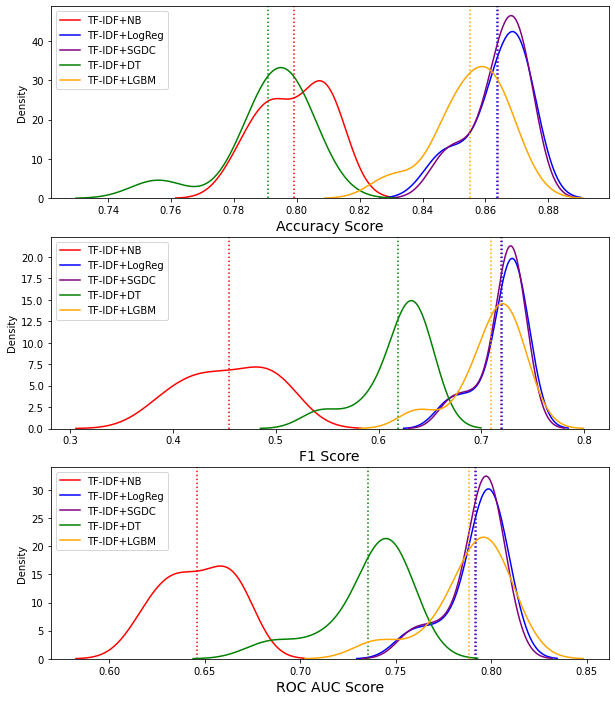

In [149]:
# List to store all models
models_tfidf = [tfidf_nb, tfidf_logreg, tfidf_sgdc, tfidf_dt, tfidf_lgbm]

# Plot histograms of accuracy, f1, and roc auc scores
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))

# Iterate over all models
for i, model in enumerate(models_tfidf):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score_base, ax=ax1, color=colors[i], label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score_base), color=colors[i], ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy Score', fontsize=14)
    
    # Plot F1 score
    sns.kdeplot(model.cv_f1_score_base, ax=ax2, color=colors[i], label=model.name)
    ax2.axvline(x=np.mean(model.cv_f1_score_base), color=colors[i], ls=':')
    
    ax2.legend()
    ax2.set_xlabel('F1 Score', fontsize=14)

    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score_base, ax=ax3, label=model.name, color=colors[i])
    ax3.axvline(x=np.mean(model.cv_roc_auc_score_base), color=colors[i], ls=':')
    
    ax3.legend()
    ax3.set_xlabel('ROC AUC Score', fontsize=14)

Using TF-IDF as our vectorizer, the best-performing models are the logistic regression, stochastic gradient descent, and LGBM. These models perform better than when bag-of-words vectorizer is used. Another interesting part, the naive bayes performs significantly worse when using TF-IDF.

# 6. Hyperparameter Tuning

We have established our baseline model and using TF-IDF as our text representation. Since our dataset From the results above, the most promising models are logistic regression and stochastic gradient descent. We will focus only on these three models and see if we can still improve the model performance by tuning the hyperparameters and equal sampling of the target classes.

In [313]:
# Dictionary for Bayesian search
# Vectorizer
param_vec = {
    'vec__ngram_range': hp.choice('ngram_range',[(1,2)]),
    'vec__max_df': hp.choice('max_df',[0.5, 0.75, 1.0]),
    'vec__min_df': hp.choice('min_df',[1, 5, 10, 15]),
    'vec__max_features': hp.choice('max_features',[None, 500, 1000])
}

# Range of hyperparameters for the classifiers
# Classifier: naive bayes
param_nb = {
    'clf__alpha': hp.loguniform('alpha', -3, 1)
}

# Classifier: Logistic Regression
param_logreg = {
    'clf__C': hp.loguniform('C', -3, 1),
    'clf__penalty': hp.choice('penalty', ['l2', 'none']),
    'clf__solver': hp.choice('solver', ['newton-cg', 'lbfgs'])
}

# Classifier: SGDC
param_sgdc = {
    'clf__alpha': hp.choice("alpha", np.logspace(-6, -3, 4)),
    'clf__penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet']),
    'clf__learning_rate': hp.choice("learning_rate", ['constant', 'optimal', 'adaptive']),
    'clf__eta0': hp.choice("eta0", [0.1, 1., 10., 100.])
}

# Classifier: Decision Tree
param_dt = {
    'clf__criterion': hp.choice('criterion', ['gini', 'entropy']),
    'clf__max_depth': hp.choice("max_depth_dtree", np.arange(100, 900, 100)),
    'clf__min_samples_leaf': hp.choice('min_samples_leaf', [5, 10, 15, 20])
}

# Classifier: LGBM
param_lgbm = {
    'clf__max_depth': hp.choice('max_depth', np.arange(-1, 100, 1)),
    'clf__num_leaves': hp.choice('num_leaves', np.arange(20, 3000)),
    'clf__n_estimators': hp.choice('n_estimators', np.arange(100, 1000, 100)),
    'clf__min_child_samples': hp.choice('min_child_samples', np.arange(1, 20, 1)),
    'clf__n_jobs': hp.choice('n_jobs', [-1]),
    'clf__learning_rate': hp.loguniform('C', -1, 2)
}

### a. TF-IDF+Naive Bayes

In [151]:
# Use bayesian search
tfidf_nb.bayes_search(space={**param_vec, **param_nb})

100%|██████████| 50/50 [03:26<00:00,  4.13s/it, best loss: 0.2546432320961598]


In [152]:
# Print the best hyperparameters
tfidf_nb.best_params_hp

{'clf__alpha': 0.05111858683679054,
 'vec__max_df': 0.75,
 'vec__max_features': None,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 2)}

In [153]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_nb.train_and_evaluate(use_best_hp=True)

Accuracy score: 87.07%
Recall score: 68.829%
Precision score:  81.788%
F1 score:  74.736%
ROC AUC score: 0.815


### b. TF-IDF + Logistic Regression

In [154]:
# Use bayesian search
tfidf_logreg.bayes_search(space={**param_vec, **param_logreg})

100%|██████████| 50/50 [05:39<00:00,  6.80s/it, best loss: 0.2523101668653245]


In [155]:
# Print the best hyperparameters
tfidf_logreg.best_params_hp

{'clf__C': 2.65013146342558,
 'clf__penalty': 'l2',
 'clf__solver': 'lbfgs',
 'vec__max_df': 0.75,
 'vec__max_features': None,
 'vec__min_df': 10,
 'vec__ngram_range': (1, 2)}

In [156]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_logreg.train_and_evaluate(use_best_hp=True)

Accuracy score: 87.279%
Recall score: 68.048%
Precision score:  83.208%
F1 score:  74.837%
ROC AUC score: 0.814


### c. TF-IDF + Stochastic Gradient Descent

In [314]:
# Use bayesian search
tfidf_sgdc.bayes_search(space={**param_vec, **param_sgdc})

100%|██████████| 50/50 [04:13<00:00,  5.08s/it, best loss: 0.23433859066388207]


In [315]:
# Print the best hyperparameters
tfidf_sgdc.best_params_hp

{'clf__alpha': 1e-05,
 'clf__eta0': 0.1,
 'clf__learning_rate': 'optimal',
 'clf__penalty': 'elasticnet',
 'vec__max_df': 1.0,
 'vec__max_features': None,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 2)}

In [316]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_sgdc.train_and_evaluate(use_best_hp=True)

Accuracy score: 87.522%
Recall score: 72.979%
Precision score:  80.426%
F1 score:  76.487%
ROC AUC score: 0.831


### d. TF-IDF + Decision Tree

In [160]:
# Use bayesian search
tfidf_dt.bayes_search(space={**param_vec, **param_dt})

100%|██████████| 50/50 [07:32<00:00,  9.05s/it, best loss: 0.3954362735907362]


In [161]:
# Print the best hyperparameters
tfidf_dt.best_params_hp

{'clf__criterion': 'entropy',
 'clf__max_depth': 800,
 'clf__min_samples_leaf': 5,
 'vec__max_df': 1.0,
 'vec__max_features': 1000,
 'vec__min_df': 15,
 'vec__ngram_range': (1, 2)}

In [162]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_dt.train_and_evaluate(use_best_hp=True)

Accuracy score: 78.955%
Recall score: 56.986%
Precision score:  63.614%
F1 score:  60.098%
ROC AUC score: 0.722


### e. TF-IDF + LGBM

In [163]:
# Use bayesian search
# tfidf_lgbm.bayes_search(space={**param_vec, **param_lgbm})

In [164]:
# Print the best hyperparameters
# tfidf_lgbm.best_params_hp

In [165]:
# Evaluate model with cross-validation using the best hyperparameters
# tfidf_lgbm.train_and_evaluate(use_best_hp=True)

### Compare the models

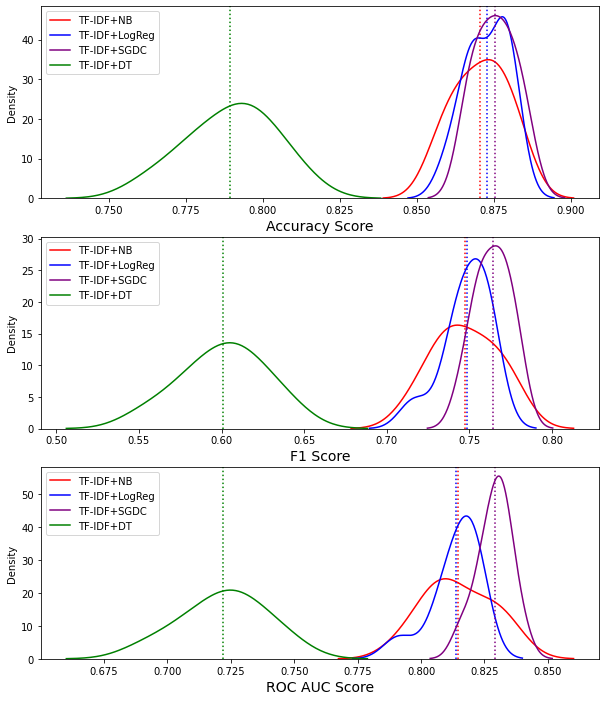

In [166]:
# List to store all models
models_best = [tfidf_nb, tfidf_logreg, tfidf_sgdc, tfidf_dt]#, tfidf_lgbm]

# Plot histograms of accuracy, f1, and roc auc scores
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))

# Iterate over all models
for i, model in enumerate(models_best):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score_hp, ax=ax1, color=colors[i], label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score_hp), color=colors[i], ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy Score', fontsize=14)
    
    # Plot F1 score
    sns.kdeplot(model.cv_f1_score_hp, ax=ax2, color=colors[i], label=model.name)
    ax2.axvline(x=np.mean(model.cv_f1_score_hp), color=colors[i], ls=':')
    
    ax2.legend()
    ax2.set_xlabel('F1 Score', fontsize=14)

    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score_hp, ax=ax3, label=model.name, color=colors[i])
    ax3.axvline(x=np.mean(model.cv_roc_auc_score_hp), color=colors[i], ls=':')
    
    ax3.legend()
    ax3.set_xlabel('ROC AUC Score', fontsize=14)

# 8. Imbalance Handling

We already know in the EDA section that our dataset is imbalanced, where the majority class, `Recommended`, is more than three times as many as the minority class, `Not Recommended`. We will now try to balance the classes and see if we can still improve our model performance. We will only use the undersampling method of the majority class, since ~4000 reviews should be plenty enough to train our model.

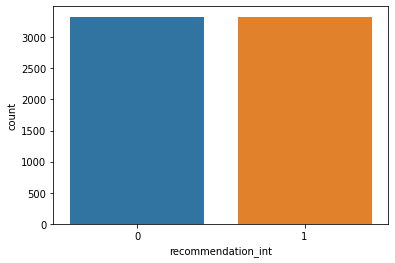

In [167]:
# Import undersampling
from imblearn.under_sampling import RandomUnderSampler

X = df_train[['clean_review']]
y = df_train[['recommendation_int']]

# Undersampling
X_under, y_under = RandomUnderSampler(random_state=42).fit_resample(X,y)
data_under = X_under.join(y_under)

# Check count plot
sns.countplot(x='recommendation_int',data=data_under)

### a. TF-IDF + Naive Bayes

In [168]:
# Define the model
tfidf_nb_balanced = Model('TF-IDF+NB', data_under, TfidfVectorizer(), MultinomialNB())

In [169]:
# Perform bayesian search
tfidf_nb_balanced.bayes_search(space={**param_vec, **param_nb})

100%|██████████| 50/50 [02:14<00:00,  2.70s/it, best loss: 0.14655482062820457]


In [170]:
# Evaluate with cross validation
tfidf_nb_balanced.train_and_evaluate(use_best_hp=True)

Accuracy score: 84.896%
Recall score: 88.97%
Precision score:  82.35%
F1 score:  85.497%
ROC AUC score: 0.849


### b. TF-IDF + Logistic Regression

In [171]:
# Define the model
tfidf_logreg_balanced = Model('TF-IDF+LogReg', data_under, TfidfVectorizer(), LogisticRegression())

In [172]:
# Perform bayesian search
tfidf_logreg_balanced.bayes_search(space={**param_vec, **param_logreg})

100%|██████████| 50/50 [03:48<00:00,  4.57s/it, best loss: 0.15071172558237045]


In [173]:
# Evaluate with cross validation
tfidf_logreg_balanced.train_and_evaluate(use_best_hp=True)

Accuracy score: 84.61%
Recall score: 87.706%
Precision score:  82.636%
F1 score:  85.068%
ROC AUC score: 0.846


### c. TF-IDF + Stochastic Gradient Descent

In [174]:
# Instantiate the model
tfidf_sgdc_balanced = Model('TF-IDF+SGDC', data_under, TfidfVectorizer(), SGDClassifier(loss='log', random_state=42))

In [175]:
# Perform bayesian search
tfidf_sgdc_balanced.bayes_search(space={**param_vec, **param_sgdc})

100%|██████████| 50/50 [02:28<00:00,  2.98s/it, best loss: 0.14848731551097172]


In [176]:
# Evaluate with cross validation
tfidf_sgdc_balanced.train_and_evaluate(use_best_hp=True)

Accuracy score: 84.671%
Recall score: 86.474%
Precision score:  83.515%
F1 score:  84.937%
ROC AUC score: 0.847


### d. TF-IDF + Decision Tree

In [177]:
# Instantiate the model
tfidf_dt_balanced = Model('TF-IDF+DT', data_under, TfidfVectorizer(), DecisionTreeClassifier(random_state=42))

In [178]:
# Perform bayesian search
tfidf_dt_balanced.bayes_search(space={**param_vec, **param_dt})

100%|██████████| 50/50 [04:01<00:00,  4.84s/it, best loss: 0.25534260668234376]


In [179]:
# Evaluate with cross validation
tfidf_dt_balanced.train_and_evaluate(use_best_hp=True)

Accuracy score: 74.315%
Recall score: 68.227%
Precision score:  77.709%
F1 score:  72.601%
ROC AUC score: 0.743


### e. TF-IDF + LGBM

In [180]:
# Instantiate the model
# tfidf_lgbm_balanced = Model('TF-IDF+LGBM', data_under, TfidfVectorizer(), LGBMClassifier(random_state=42))

In [181]:
# Perform bayesian search
# tfidf_lgbm_balanced.bayes_search(space={**param_vec, **param_lgbm})

In [182]:
# Evaluate with cross validation
# tfidf_lgbm_balanced.train_and_evaluate(use_best_hp=True)

### Compare the models

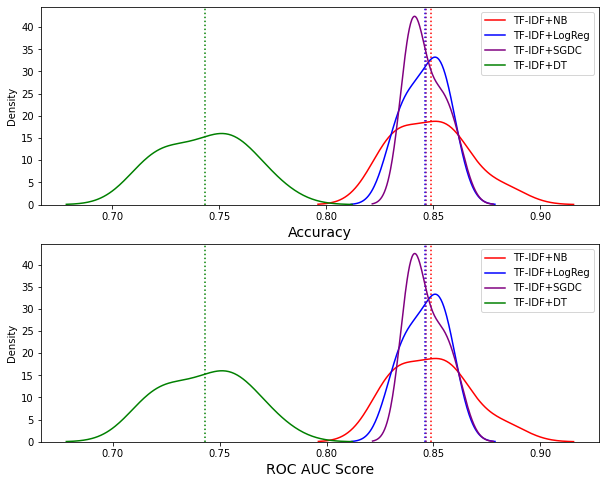

In [183]:
# List to store all models
models_best = [tfidf_nb_balanced, tfidf_logreg_balanced, tfidf_sgdc_balanced, tfidf_dt_balanced]#,tfidf_lgbm_balanced]
colors = ['red', 'blue', 'purple', 'green', 'orange']

# Plot histogram of roc accuracy score
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

for i, model in enumerate(models_best):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score_hp, ax=ax1, color=colors[i], label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score_hp), color=colors[i], ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy', fontsize=14)
    
    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score_hp, ax=ax2, label=model.name, color=colors[i])
    ax2.axvline(x=np.mean(model.cv_roc_auc_score_hp), color=colors[i], ls=':')
    
    ax2.legend()
    ax2.set_xlabel('ROC AUC Score', fontsize=14)

It looks like training our model on a balanced dataset does not improve the performance significantly. However, one advantage of balancing the dataset is that the accuracy score can now be interpreted more objectively. Based on the average score from cross-validation, the best-performing model is the TF-IDF+LogReg, which is consistent with the results obtained from the original training set, followed by TF-IDF+SGDC and TF-IDF+NB. 

Therefore, we will choose TF-IDF+LogReg with the obtained hyperparameters as our best and final model, and use it to make predictions on the test data.

# 7. Model Evaluation

In [317]:
# Make new variables for baseline model and best/final model
baseline_model = bow_nb
best_model = tfidf_sgdc

In [318]:
# Make predictions on test data using baseline model
baseline_model.predict_test(df_test, False)

Model: BOW+NB 

Confusion matrix: 
 [[3426  206]
 [ 536  961]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.94      0.90      3632
           1       0.82      0.64      0.72      1497

    accuracy                           0.86      5129
   macro avg       0.84      0.79      0.81      5129
weighted avg       0.85      0.86      0.85      5129



TN - True Positive: 961
FP - False Negative: 536
FN - False Positive: 206
TP - True Negative: 3426
Accuracy Rate: 85.5%
Misclassification Rate: 14.499999999999998%
Recall: 0.642
Precision: 0.823
F1-Score: 0.721
ROC-AUC score: 0.793


In [319]:
# Predictions on test data using our best model
best_model.predict_test(df_test, True)

Model: TF-IDF+SGDC 

Confusion matrix: 
 [[3376  256]
 [ 410 1087]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      3632
           1       0.81      0.73      0.77      1497

    accuracy                           0.87      5129
   macro avg       0.85      0.83      0.84      5129
weighted avg       0.87      0.87      0.87      5129



TN - True Positive: 1087
FP - False Negative: 410
FN - False Positive: 256
TP - True Negative: 3376
Accuracy Rate: 87.0%
Misclassification Rate: 13.0%
Recall: 0.726
Precision: 0.809
F1-Score: 0.765
ROC-AUC score: 0.828


Whoa, it looks like our best model performs much better on the test set than during the cross-validation with the training data! This number seems too good to be true though, so it's a good idea to be skeptical about this result and test this same model on larger dataset from different sources.

Let's see what words are strongly associated with good reviews, and words that are associated with bad reviews.

### Check features

In [280]:
# Use eli5
# !pip install eli5

In [320]:
import eli5

eli5.show_weights(best_model.pipeline_hp, vec=best_model.pipeline_hp.named_steps["vec"], top=50)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+12.903,refund
+10.254,wast
+9.633,trash
+8.110,terribl
+7.409,poor
+7.398,ea
+7.085,even
+6.902,garbag
+6.711,crash
+6.546,worst


Words with positive weights are 'great', 'best', 'amazing', etc. They seem to be mostly compliments to the games, and they are not that useful as feedback for game developers. However, some of the negative words are 'mod', 'crash', 'cheater', 'hacker', and 'lag'. Among the top games in this dataset are PUBG and Rust, which are both FPS games. And as someone who plays FPS game, these problems are also commonly found in other FPS games I have played, which made my gaming experience not pleasant. So it looks like our model has captured the most important problems from the opinions of the reviewers.

Let's plot the ROC and precision-recall curve to see how our model has improved the baseline model.

### Plot ROC curve

In [321]:
# Use base model for the baseline, tuned model for the best model
use_hp = [False, True]

# Function to plot ROC curve
def plot_roc(models, colors, labels):
    # Define figure object
    plt.figure(figsize=(6,6))

    for i, model in enumerate(models):
        model.get_roc(color=colors[i], label=labels[i], use_best_hp=use_hp[i])

    # Extra touch
    plt.plot([0.,1.], [0.,1.], color='k', ls='--', label='random classifier')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC curve', fontsize=14)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.legend(loc='lower right')
    plt.show()
    return

# Function to plot precision-recall curve
def plot_prc(models, colors, labels):
    # Define figure object
    plt.figure(figsize=(6,6))
    
    for i, model in enumerate(models):
        model.get_prc(color=colors[i], label=labels[i], use_best_hp=use_hp[i])

    # Extra touch
    plt.axhline(y=models[0].y_noskill, color='k', ls='--', label='random classifier')
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-recall curve', fontsize=14)
    plt.xlim(0., 1.)
    plt.legend(loc='center left')
    plt.show()
    return

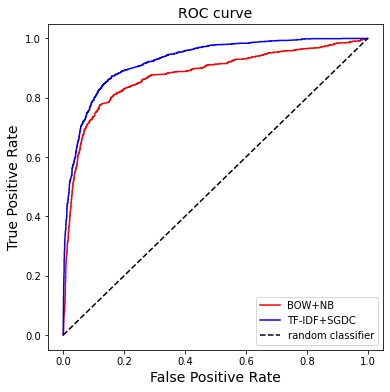

In [322]:
models_best = [baseline_model, best_model]
colors = ['red', 'blue']
labels = [baseline_model.name, best_model.name]

plot_roc(models_best,colors,labels)

### Plot precision-recall curve

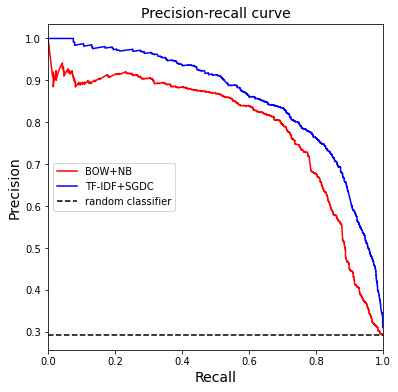

In [323]:
plot_prc(models_best,colors,labels)

### Save the model

In [333]:
import joblib

path = '/content/drive/MyDrive/Colab Notebooks/steam_reviews_2.0/model/'

joblib.dump(best_model.pipeline_hp, path+'tfidf_sgdc.joblib.dat')

['/content/drive/MyDrive/Colab Notebooks/steam_reviews_2.0/model/tfidf_sgdc.joblib.dat']

### Try the model (check if works)

In [334]:
test_model = joblib.load(path+'tfidf_sgdc.joblib.dat')

In [339]:
X_test = df_test['clean_review']
y_test = df_test['recommendation_int']

y_pred = test_model.predict(X_test)
model_evaluation('test', y_test, y_pred)

Model: test 

Confusion matrix: 
 [[3376  256]
 [ 410 1087]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      3632
           1       0.81      0.73      0.77      1497

    accuracy                           0.87      5129
   macro avg       0.85      0.83      0.84      5129
weighted avg       0.87      0.87      0.87      5129



TN - True Positive: 1087
FP - False Negative: 410
FN - False Positive: 256
TP - True Negative: 3376
Accuracy Rate: 87.0%
Misclassification Rate: 13.0%
Recall: 0.726
Precision: 0.809
F1-Score: 0.765
ROC-AUC score: 0.828


# Conclusions:

1. We have analyzed a subset of the Steam Games Reviews dataset from Kaggle.
2. Most of the reviews are positive, with frequent words such as 'awesome', 'fun', and 'love'. While the negative reviews are filled with words such as 'cheater', 'bug', and 'hacker'.
3. We have applied standard text cleaning to clean the reviews: removing punctuations, digits, stop words, and stemming.
4. We set our baseline model as BOW + Naive Bayes, as it is commonly used in text classification such as spam detection. After trying out models using TF-IDF as the vectorizer and employing hyperparameter tuning using the Bayesian search, our best model is the TF-IDF+logistic regression (TF-IDF+LogReg).
5. From the cross-validation method using the test data, the TF-IDF+LogReg model yields an accuracy of 84.603% and an ROC AUC score of 0.779. These numbers increased to 85.465% for accuracy and 0.802 for ROC AUC.
6. We find that training the model on a balanced training set using undersampling method does not improve the performance significantly.
7. The baseline model, which we take to be BOW+NB, yields an accuracy of 83.6% and an ROC AUC score of 0.784 on the test data. Whereas the TF-IDF+LogReg yields an accuracy of 94.2% and an ROC AUC score of 0.916 on the test data, and so we have built a model with a much better performance than our baseline model. This accuracy seems to be too high, and so it may be better to immediately test it on a new, unseen dataset from a different source.